# Dataset_Maker_Lines

### Description:

Script to create dataset of lines.

Also includes option to add junctions and uniform regions for training.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from types import SimpleNamespace
import sys
sys.path.append('..')
from field_of_junctions import FieldOfJunctions
import os
import pickle, os
from PIL import Image
import nbimporter

# dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dev = 'cpu'

In [2]:
def make_random_line_set(num_samples,R,dev,zero_center,delta=.25,eta=0.005):

    y, x = torch.meshgrid([torch.linspace(-1.0, 1.0, R, device=dev),
                               torch.linspace(-1.0, 1.0, R, device=dev)],indexing='ij')

    # Randomly generate angle, center is automatically (0,0) — but can eventually be modified
    
    if zero_center:
        jcenter = torch.zeros(num_samples,2).to(dev)
    else: 
        jcenter = (torch.rand(num_samples,2)*.8-.4).to(dev)
        # within [-.4,.4] 40% of the center
#         jcenter = (torch.rand(num_samples,2)*1.5-.75).to(dev)
        
    jangle = 2*np.pi*torch.rand(num_samples,1).to(dev)
    
    # Concatenate to form full set of parameters [output 4]
    params = torch.cat([jangle,jcenter],dim=1).unsqueeze(2).unsqueeze(3)

    # Define the three parameters
    angle = params[:, 0, :, :]   # shape [N, 1, 1, H', W']
    x0 = params[:, 1, :, :]   # shape [N, 1, 1, H', W']
    y0 = params[:, 2, :, :]   # shape [N, 1, 1, H', W']

    # Convert the angle into a and b
    a = -torch.sin(angle)
    b = torch.cos(angle)
    c = -y0*torch.cos(angle)+x0*torch.sin(angle)

    # Create distance functions and then stack to create dists [output 1]
    dist1 = a*x + b*y + c
    dist2 = -(a*x + b*y + c)
    dists = torch.stack([dist1, dist2], dim=1)
    
    # Apply smooth Heaviside function to distance functions
    hdists = 0.5 * (1.0 + (2.0 / np.pi) * torch.atan(dists / eta))
    
    # Convert Heaviside functions into wedge indicator functions [output 2]
    wedges = torch.stack([1.0 - hdists[:, 0, :, :],
                              hdists[:, 0, :, :] * (1.0 - hdists[:, 1, :, :]),
                              hdists[:, 0, :, :] *        hdists[:, 1, :, :]], dim=1)
    
    # Convert the heavyside distance functions into a boundary map
    d1 = hdists[:, 0, :, :]
    d2 = hdists[:, 1, :, :]
    
    minabsdist = torch.where(d1 < 0.0, -d1, torch.where(d2 < 0.0, torch.min(d1, -d2), torch.min(d1, d2)))

    boundaries = 1.0 / (1.0 + (minabsdist / delta) ** 2)

    return dists,wedges,boundaries,params

def make_grey_transform_lines(num_images,wedges,dev,opt=0):
    
    if opt == 0:
        return torch.tensor([.5,1],device=dev).unsqueeze(0).repeat(num_images,1).unsqueeze(2).unsqueeze(3)

    if opt == 1:  

        grey_transform = torch.zeros((wedges.shape[0],2,1,1),device=dev)

        num_grey_schemes = 0
        while num_grey_schemes<wedges.shape[0]:
            
            sample = torch.rand(2).sort()[0]

            if torch.min(torch.diff(sample))<.2:
                continue

            grey_transform[num_grey_schemes,:,:,:] = sample.unsqueeze(1).unsqueeze(1)

            num_grey_schemes += 1

        return grey_transform

torch.Size([100, 3, 12, 12])


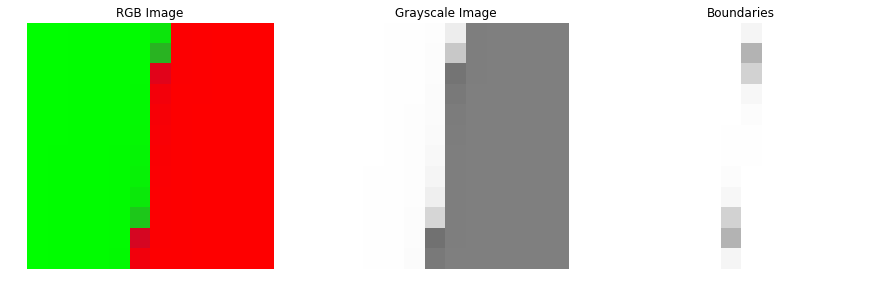

In [4]:
num_samples = 100
R = 12
    
dists,wedges,boundaries,params = make_random_line_set(num_samples,R,dev,1,delta=.25)#,eta=0.005)

grey_transform = make_grey_transform_lines(num_samples,wedges,dev,opt=0)

print(wedges.shape)

wedges_grey = (wedges[:,:2,:,:]*grey_transform).sum(1).squeeze(1)


img_show = 0
plt.figure(figsize=[15, 15])
plt.subplot(131)
plt.imshow(wedges[img_show,:,:].squeeze().permute(1,2,0).cpu())
plt.title('RGB Image')
plt.axis('off');
plt.subplot(132)
plt.imshow(wedges_grey[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Grayscale Image')
plt.axis('off');
plt.subplot(133)
plt.imshow(boundaries[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Boundaries')
plt.axis('off');

### Add noise

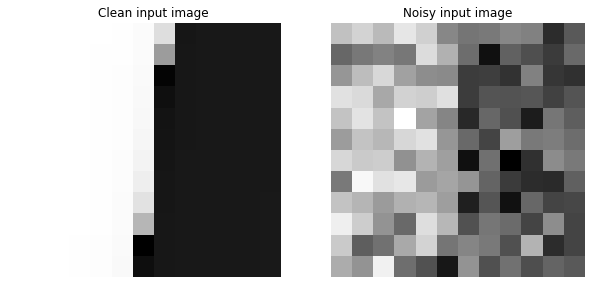

In [5]:
# Red square on black background
# Add noise
# Red square on black background
clean_img = wedges_grey[img_show,:,:].cpu().squeeze()

# Add noise
img = clean_img + .2*np.random.randn(*clean_img.shape)
mn, mx = img.min(), img.max()

# Adjust contrast (equally to both images)
img = (img - mn) / (mx - mn)
clean_img = (clean_img - mn) / (mx - mn)

plt.figure(figsize=[10, 10])
plt.subplot(121)
plt.imshow(clean_img,cmap='gray')
plt.title('Clean input image')
plt.axis('off');
plt.subplot(122)
plt.imshow(img,cmap='gray')
plt.title('Noisy input image')
plt.axis('off');

# Example Use Cases

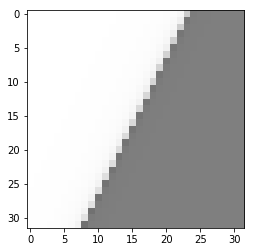

In [6]:
# Create a basic line dataset with

# 100 images
# colors = [.5,1]
# Centered lines

# A pickle file containing:
# wedges
# wedges grey
# params
# boundaries

num_samples = 100
R = 32

dists,wedges,boundaries,params = make_random_line_set(num_samples,R,dev,1)
grey_transform = make_grey_transform_lines(num_samples,wedges,dev)
wedges_grey = (wedges[:,:2,:,:]*grey_transform).sum(1).squeeze(1)

    
line_data = {'wedges':wedges,
                 'wedges_grey':wedges_grey,
                 'params': params,
                 'boundaries':boundaries}

data_folder = 'foj_data/grayscale_lines/'

# if folder doesn't exist, make it
if not os.path.exists(data_folder):
    os.makedirs(data_folder)

# with open(data_folder + 'line_data_32_100_grey_bicolor_centered.pkl', 'wb') as f:
#     pickle.dump(line_data, f)

plt.figure()
plt.imshow(wedges_grey[0].squeeze().cpu(),cmap='gray',vmin=0,vmax=1)

In [7]:
# Create a basic line dataset with

# 10,000 images
# colors = [.5,1]
# Noise added
# Centered

# A pickle file containing:
# wedges
# wedges grey
# params
# boundaries

num_samples = 10000
R = 32
add_noise = 1
centered = 1


dists,wedges,boundaries,params = make_random_line_set(num_samples,R,'cpu',centered)
grey_transform = make_grey_transform_lines(num_samples,wedges,'cpu',0)

wedges_grey = (wedges[:,:2,:,:]*grey_transform).sum(1).squeeze(1)

if add_noise:
    wedges_grey = wedges_grey + .2*torch.rand(*wedges_grey.shape)#,device=dev)
    mn, mx = wedges_grey.min(), wedges_grey.max()

    # Adjust contrast (equally to both images)
    wedges_grey = (wedges_grey - mn) / (mx - mn)

    
line_data = {'wedges':wedges,
                 'wedges_grey':wedges_grey,
                 'params': params,
                 'boundaries':boundaries}

data_folder = 'Data/grayscale_lines/'

# # if folder doesn't exist, make it
# if not os.path.exists(data_folder):
#     os.makedirs(data_folder)

# with open(data_folder + 'line_data_32_10000_grey_bicolor_noise_.2_centered.pkl', 'wb') as f:
#     pickle.dump(line_data, f)



In [9]:
# Create a basic line dataset with

# R = 16,8
# 10,000 images
# colors = [.5,1]
# Noise added — RANDOM AMOUNTS
# NOT centered

# A pickle file containing:
# wedges
# wedges grey
# params
# boundaries

num_samples = 100
R = 8
add_noise = 1
centered = 0


dists,wedges,boundaries,params = make_random_line_set(num_samples,R,'cpu',centered)

grey_transform = make_grey_transform_lines(num_samples,wedges,'cpu',0)

wedges_grey = (wedges[:,:2,:,:]*grey_transform).sum(1).squeeze(1)

if add_noise:
    wedges_grey = wedges_grey + .8*torch.rand(num_samples).unsqueeze(1).unsqueeze(1)*torch.rand(*wedges_grey.shape)#,device=dev)
    mn, mx = wedges_grey.min(), wedges_grey.max()

    # Adjust contrast (equally to both images)
    wedges_grey = (wedges_grey - mn) / (mx - mn)

    
line_data = {'wedges':wedges,
                 'wedges_grey':wedges_grey,
                 'params': params,
                 'boundaries':boundaries}

data_folder = 'Data/grayscale_lines/'

# if folder doesn't exist, make it
if not os.path.exists(data_folder):
    os.makedirs(data_folder)

# with open(data_folder + 'line_data_8_50000_grey_bicolor_noise_random_uncentered.pkl', 'wb') as f:
#     pickle.dump(line_data, f)
